# Download and process the Bay Area's walkable network

In [1]:
import time
import os, zipfile, requests, pandas as pd, geopandas as gpd, osmnx as ox, networkx as nx

ox.config(use_cache=True, log_console=True)
print('ox {}\nnx {}'.format(ox.__version__, nx.__version__))
start_time = time.time()

ox 0.7.3
nx 2.2rc1.dev_20180312064857


In [2]:
# point to the shapefile for counties
counties_shapefile_url = 'http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_500k.zip'

# identify bay area counties by fips code
bayarea = {'Alameda':'001',
           'Contra Costa':'013',
           'Marin':'041',
           'Napa':'055',
           'San Francisco':'075',
           'San Mateo':'081',
           'Santa Clara':'085',
           'Solano':'095',
           'Sonoma':'097'}

## Download and extract the counties shapefile if it doesn't already exist, then load it

To use OSMnx, we need a polygon of the Bay Area's nine counties. So, we'll download a shapefile from the census, extract our counties, and take the union to form a polygon. Also, project the polygon so we can calculate its area for density stats.

In [3]:
counties_shapefile_zip = counties_shapefile_url[counties_shapefile_url.rfind('/') + 1 :]
counties_shapefile_dir = counties_shapefile_zip[: counties_shapefile_zip.rfind('.zip')]
if not os.path.exists(counties_shapefile_dir):
    response = requests.get(counties_shapefile_url)
    with open(counties_shapefile_zip, 'wb') as f:
        f.write(response.content)
        with zipfile.ZipFile(counties_shapefile_zip, 'r') as zip_file:
            zip_file.extractall(counties_shapefile_dir)
    os.remove(counties_shapefile_zip)

In [4]:
counties = gpd.read_file(counties_shapefile_dir)
len(counties)

3233

In [5]:
# retain only those tracts that are in the bay area counties
mask = (counties['STATEFP'] == '06') & (counties['COUNTYFP'].isin(bayarea.values()))
gdf_bay = counties[mask]
len(gdf_bay)

9

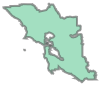

In [6]:
bayarea_polygon = gdf_bay.unary_union
bayarea_polygon

In [7]:
# get the convex hull, otherwise we'll cut out bridges over the bay
bayarea_polygon_hull = bayarea_polygon.convex_hull
bayarea_polygon_hull_proj, crs = ox.project_geometry(bayarea_polygon_hull)

In [8]:
# project by a mile to get connectivities surrounding our O-Ds
bayarea_polygon_hull_proj_buff = bayarea_polygon_hull_proj.buffer(1600) #1 mile in meters
bayarea_polygon_hull_buff, crs = ox.project_geometry(bayarea_polygon_hull_proj_buff, crs=crs, to_latlong=True)

## Download the street network then simplify it

Now we've got our polygon of the buffered convex hull around the nine county bay area. Use OSMnx to download the street network (walkable paths).

In [9]:
# retain all connected component subgraphs
G = ox.graph_from_polygon(bayarea_polygon_hull_buff, network_type='walk', simplify=False, retain_all=True)

In [10]:
# details of the unsimplified, disconnected graph
print(len(G.nodes()))
print(len(G.edges()))

2641791
5687010


In [11]:
# simplify the (disconnected) graph
G = ox.remove_isolated_nodes(G)
G = ox.simplify_graph(G, strict=True)

In [12]:
# details of the simplified, disconnected graph
print(len(G.nodes()))
print(len(G.edges()))

619889
1643238


## Retain only the largest *n* connected components

In the bay area, the entire network is not connected. There are two main subgraphs containing a substantial portion of the network. We have to retain more than one subgraph accordingly, or we lose the northern ~20% of the network. Namely, the GG Bridge is tagged as motorway and cycleway (not ped). The cycleway has a foot~designated tag, but OSMnx doesn't parse all these tags to see what might be allowed. This is a potential future enhancement. For now, you could manually add an edge across the golden gate.

In [13]:
print(nx.is_weakly_connected(G), nx.is_strongly_connected(G))

False False


In [14]:
# get all the connected components, ordered from largest to smallest
CCs = nx.strongly_connected_components(G)
sorted_CCs = sorted(list(CCs), key=len, reverse=True)
len(sorted_CCs)

7419

In [15]:
# retain nodes in components that contains at least *threshold* share of the full graph
threshold = 0.01 #1%

nodes_subset = []
for CC in sorted_CCs:
    if len(CC) / len(G) > threshold:
        print(round(len(CC) / len(G), 3))
        nodes_subset.extend(list(CC))
        
len(nodes_subset)

0.669
0.214


547089

In [16]:
# induce a subgraph of G on the nodes of these connected components
G_discon = ox.induce_subgraph(G, nodes_subset)
len(G_discon)

547089

In [17]:
# get all the connected components, ordered from largest to smallest
CCs = nx.strongly_connected_components(G_discon)
sorted_CCs = sorted(list(CCs), key=len, reverse=True)
len(sorted_CCs)

2

In [18]:
# create a unique ID for each edge because osmid can hold multiple values due to topology simplification
i = 0
for u, v, k, d in G_discon.edges(data=True, keys=True):
    d['uniqueid'] = i
    i += 1

## See some descriptive stats then save to disk

In [19]:
print(len(G_discon.nodes()))
print(len(G_discon.edges()))

547089
1503846


In [20]:
# see some basic network stats
# note, areas/densities include water
pd.Series(ox.basic_stats(G_discon, area=bayarea_polygon_hull_proj_buff.area))

circuity_avg                                                               1.16074
clean_intersection_count                                                      None
clean_intersection_density_km                                                 None
edge_density_km                                                            6006.37
edge_length_avg                                                            113.919
edge_length_total                                                      1.71317e+08
intersection_count                                                          434896
intersection_density_km                                                    15.2475
k_avg                                                                      5.49763
m                                                                          1503846
n                                                                           547089
node_density_km                                                             19.181
self

In [21]:
# save nodes and edges list as csv
nodes, edges = ox.graph_to_gdfs(G_discon, node_geometry=False, fill_edge_geometry=False)

ecols = ['uniqueid', 'u', 'v', 'key', 'oneway', 'highway', 'name', 'length',
         'lanes', 'width', 'est_width', 'maxspeed', 'access', 'service',
         'bridge', 'tunnel', 'area', 'junction', 'osmid', 'ref']

edges = edges.drop(columns=['geometry']).reindex(columns=ecols)
nodes = nodes.reindex(columns=['osmid', 'x', 'y', 'ref', 'highway'])

nodes.to_csv('data/walk_network_discon/bayarea_walk_nodes.csv', index=False, encoding='utf-8')
edges.to_csv('data/walk_network_discon/bayarea_walk_edges.csv', index=False, encoding='utf-8')

In [22]:
# save as graphml for re-using later
ox.save_graphml(G_discon, filename='bayarea_walk_discon.graphml', folder='data/walk_network_discon')

In [23]:
# save as shapefile for GIS
ox.save_graph_shapefile(G_discon, filename='bayarea_walk_discon', folder='data/walk_network_discon')

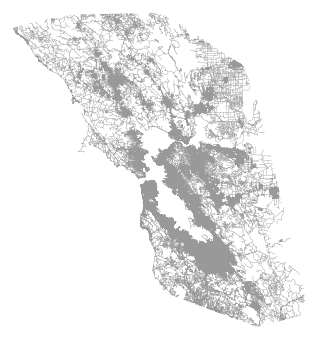

In [24]:
# visualize the network
fig, ax = ox.plot_graph(G_discon, node_size=0, edge_linewidth=0.2)

In [25]:
time.time() - start_time

2801.4044559001923